https://github.com/IlliaOvcharenko/lung-segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master')

In [ ]:
import torch
import torchvision
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data loading

In [ ]:
class CXRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'cxr')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.split('.')[0] + '.png'  # Assuming mask files have the same name as the corresponding image files
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert('L') #--> image value in range [0,1]
        mask = Image.open(mask_path).convert('L') #--> mask value in range [0,1]

        if self.transform:
            image = self.transform(image)
            resized_mask = self.transform(mask)
            threshold = 0.5
            binary_mask = (resized_mask > threshold).float()
        return image, binary_mask

# Example usage:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize((0.5, 0.5), (0.5, 0.5))  # Normalize image tensors
])

dataset = CXRDataset('/content/drive/MyDrive/Projects/Pulsar-AI/Datasets/v7_cxr', transform=data_transform)

# Split the dataset into train and validation sets
train_ratio = 0.8  # Percentage of data for training
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders for train and validation sets
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers = 2,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers = 2,shuffle=False)

## Check dataloading

In [ ]:
import matplotlib.pyplot as plt

dataloader_check = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterate over the data loader to get the first batch (size = 1)
for images, masks in dataloader_check:
    sample_image = images[0]  # Extract the first image from the batch --> image value in range [0,1]
    sample_mask = masks[0]  # Extract the corresponding mask --> mask value in range [0,1]
    print(sample_image)
    print(sample_image.shape)
    print(sample_mask)
    print(sample_mask.shape)

    # Convert tensor to numpy array
    sample_image = sample_image.permute(1, 2, 0).numpy()
    sample_mask = sample_mask.squeeze().numpy()
    print(sample_image.shape)

    print(sample_mask.shape)

    # Denormalize the image (if it was normalized in the transforms)
    # sample_image = sample_image * 0.5 + 0.5

    # Plot the sample image and mask
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Sample Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask, cmap='gray')
    plt.title('Sample Mask')
    plt.axis('off')

    plt.show()
    break  # Stop after processing the first batch


## Model training

In [ ]:
# unet = UNet(in_channels=1, out_channels=2, batch_norm=True)
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)
unet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:01<00:00, 310MB/s]


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [ ]:
unet = unet.to(device)
# optimizer = torch.optim.SGD(unet.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [ ]:
train_log_filename = "train-log.txt"
epochs = 1
best_val_loss = np.inf
model_name = "unet-6v.pt"

In [ ]:
import pdb

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()

    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in train_loader:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outs = unet(origins)
        # pdb.set_trace()
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks.squeeze(1).long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * num
        print(".", end="")

    train_loss = train_loss / len(train_dataset)
    print()


    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in val_loader:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks.squeeze(1).long()).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks.squeeze(1).long(), outs.float()).item() * num
            val_dice += dice(masks.squeeze(1).long(), outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(val_dataset)
    val_jaccard = val_jaccard / len(val_dataset)
    val_dice = val_dice / len(val_dataset)
    print()


    end_t = time.time()
    spended_t = end_t - start_t

    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), '/content/drive/MyDrive/Projects/Pulsar-AI/saved_models')
            print("model saved")
            train_log_file.write("model saved\n")
        print()


train phase
..............................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: ignored

epochs: 100, overall time: 227.0m, mean epoch time: 136.41898714780808s


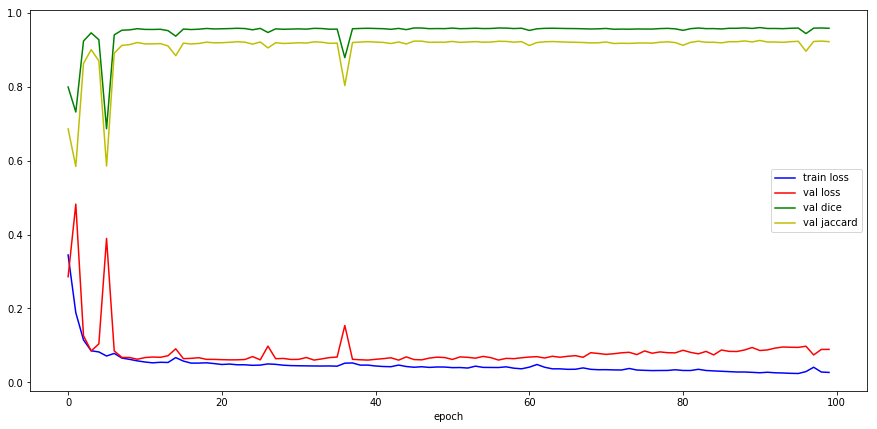

In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [ ]:
torch.cuda.empty_cache()

## Evaluate

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
 11%|█         | 54.3M/507M [00:01<00:10, 44.5MB/s]


KeyboardInterrupt: ignored

In [ ]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

In [ ]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase],
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")

plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")

## Inference


In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 80.7MB/s]


In [ ]:
model_name = "unet-model1.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1.pt", map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
device

device(type='cpu')

## Inference from Montgomery

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/MontgomerySet/CXR_png" # read from Montogomery dataset in VeyTel
save_dir = "/content/drive/MyDrive/Projects/Pulsar-AI/output/model4/montgomery/"

isExist = os.path.exists(save_dir)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(save_dir)
   print(" new save directory created")

for i in range(50):
  image_name_ = "MCUCXR_" +str(i).rjust(4, '0') + "_0"
  image_name = image_name_ +".png"

  image_path = os.path.join(image_dir, image_name)
  if(os.path.isfile(image_path)):
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")

        pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
        input_cxr = np.array(pil_origin)
        # pdb.set_trace()
        out1 = np.array(np.repeat(out,3,1).reshape(256,256,3))
        segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
        cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
        im1 = Image.fromarray(cat_image)
        im1.save(save_dir + image_name_ + "_out.png")


  # plt.figure(figsize=(10, 5))

  # pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")

  # plt.subplot(1, 2, 1)
  # plt.title("input CXR")
  # plt.imshow(np.array(pil_origin))

  # plt.subplot(1, 2, 2)
  # plt.title("segmented lung")
  # out1 = np.array(np.repeat(out,3,1).reshape(256,256,3))
  # plt.imshow(np.array(pil_origin) * out1);

 new save directory created


## Inference from UPMC-ARDS

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir = "/content/drive/MyDrive/Projects/Pulsar-AI/output/model4/UPMC-ARDS/"
isExist = os.path.exists(save_dir)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(save_dir)
   print(" new save directory created")

arr = os.listdir(image_dir)
for i in range(50):
  image_path = os.path.join(image_dir, arr[i])
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3))
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      im1 = Image.fromarray(cat_image)
      im1.save(save_dir + arr[i])

 new save directory created


## Inference from random images

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
original = torchvision.io.read_image(image_path)
print("original size of image is",original.shape) #[C, H, W]

original size of image is torch.Size([3, 2020, 1780])


out_upsample = torch.Size([1, 2020, 1780])
shape of out_reshape =  torch.Size([2020, 1780, 3])


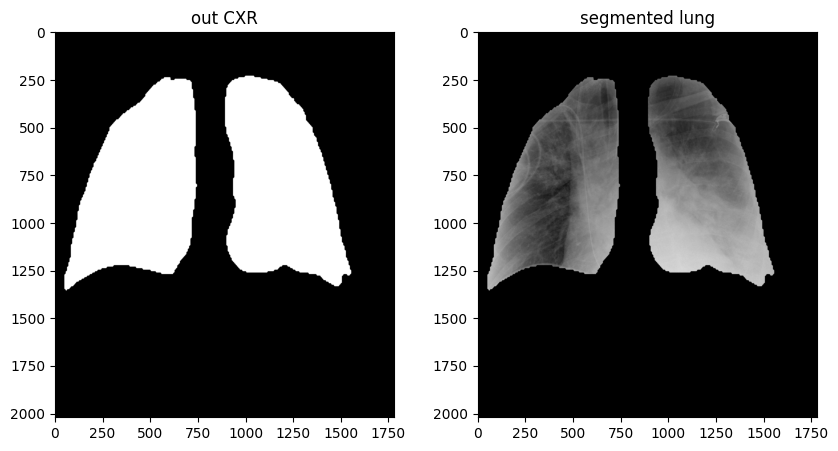

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
origin1 = Image.open(image_path)
origin = Image.open(image_path).convert("L")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin1 = torchvision.transforms.functional.to_tensor(origin1)
height = origin1.shape[1]
width = origin1.shape[2]

with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)

    origin = origin[0].to("cpu")
    out = out[0].to("cpu")
    plt.figure(figsize=(10, 5))

    # plt.imshow(origin_reshape1)
    out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
    threshold = 0.5
    out_upsample = (out_upsample > threshold).float()
    print("out_upsample =", out_upsample.shape)

    plt.subplot(1, 2, 1)
    plt.title("out CXR")
    out_reshape = torch.permute(out_upsample,(1,2,0))
    out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
    plt.imshow(out_reshape1)

    plt.subplot(1, 2, 2)
    plt.title("segmented lung")
    origin_reshape = torch.permute(origin1,(1,2,0))
    print("shape of out_reshape = ",origin_reshape.shape)
    segmented_lung = out_reshape1 * origin_reshape
    plt.imshow(segmented_lung);

In [ ]:
segmented_lung.shape

torch.Size([2020, 1780, 3])

In [ ]:
y1 = torch.min(out_reshape.nonzero()[:,0])
y2 = torch.max(out_reshape.nonzero()[:,0])
x1 = torch.min(out_reshape.nonzero()[:,1])
x2 = torch.max(out_reshape.nonzero()[:,1])
print(y1,y2,x1,x2)

tensor(229) tensor(1356) tensor(49) tensor(1550)


torch.Size([1127, 1501, 3])


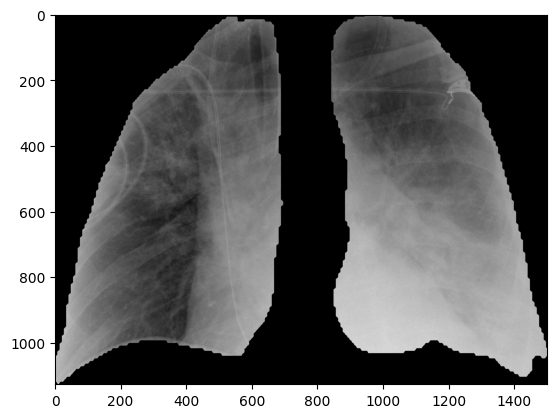

In [ ]:
cropped_lung = segmented_lung[y1:y2,x1:x2,:]
print(cropped_lung.shape)
plt.imshow(cropped_lung)

In [ ]:
import csv

# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/Datasets/cropping_data.csv'

# Write the data to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['image_name', 'folder', 'x', 'y', 'width', 'height'])
    writer.writeheader()
    for i in range(5):
      data = [
      {'image_name': 'image1.jpg', 'folder': 'folder1', 'x': 10, 'y': 20, 'width': 100*i, 'height': 100},
      {'image_name': 'image2.jpg', 'folder': 'folder2', 'x': 50, 'y': 60, 'width': 150, 'height': 200},
      ]
      writer.writerows(data)


In [ ]:
arr = os.listdir("/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS")

KeyboardInterrupt: ignored

# Inference from Individual Folders of UPMC data

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC-ARDS" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC-ARDS" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC-ARDS" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC-ARDS" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 492/492 [08:43<00:00,  1.06s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ARDS_V2.2.2" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ARDS_V2.2.2" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 115/115 [02:29<00:00,  1.30s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ARDS_V2.2.3" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ARDS_V2.2.3" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ARDS_V2.2.4" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ARDS_V2.2.4" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 112/112 [01:53<00:00,  1.01s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_Floor_V2.1.4" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_Floor_V2.1.4" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 98/98 [02:31<00:00,  1.55s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.5" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_Floor_V2.1.5" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_Floor_V2.1.5" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 41/41 [00:58<00:00,  1.42s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi2/Images" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ProCopi2" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ProCopi2" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

100%|██████████| 191/191 [03:08<00:00,  1.02it/s]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.0" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ProCopi_V2.1.0" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ProCopi_V2.1.0" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ProCopi_V2.1.1" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ProCopi_V2.1.1" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ProCopi_V2.1.2" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ProCopi_V2.1.2" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 47/47 [00:57<00:00,  1.23s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung/UPMC_ProCopi_V2.1.3" # write to lung folder
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/UPMC_ProCopi_V2.1.3" # write to mask folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      # im1 = Image.fromarray(cat_image)
      im1 = Image.fromarray(segmented_lung)
      save_path = os.path.join(save_dir_lung, image_name)
      im1.save(save_path)
      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

new save directory created for lung segmentation
new save directory created for segmentation mask


100%|██████████| 47/47 [01:00<00:00,  1.30s/it]


In [ ]:
arr[0]

'00015_120625.png'

In [ ]:
import numpy as np
from PIL import Image

# Load the PNG image using PIL
image_pil = Image.open('/content/drive/MyDrive/Projects/Pulsar-AI/Datasets/v7_cxr/cxr/959789.png')

# Convert the PIL image to a NumPy array
image_np = np.array(image_pil)

# Print the shape and data type of the NumPy array
print('Shape:', image_np.shape)
print('Data type:', image_np.dtype)

Shape: (598, 763, 3)
Data type: uint8


## Add wires to xrays

(4072, 4952, 3)


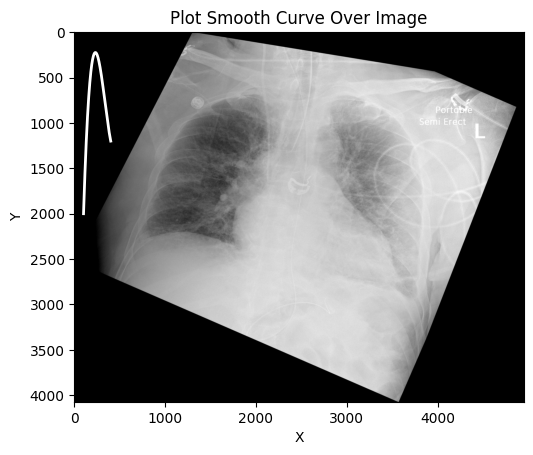

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.1/05096_200418.png"  # Replace with the actual path to your image
image = plt.imread(image_path)
print(image.shape)

# Dataset
x = np.array([100, 200, 300, 400])
y = np.array([2000, 300, 500, 1200])

X_Y_Spline = make_interp_spline(x, y)

# Returns evenly spaced numbers over a specified interval
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Plot the image
plt.imshow(image)

# Plot the smooth curve on top of the image
plt.plot(X_, Y_, color = (1,1,1), linewidth=2.0)

plt.title("Plot Smooth Curve Over Image")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [ ]:
np.cos(0)

1.0

translation =  58.952363981729626 56.48836426867606
3.6957994532970773 3.8039613789400595 -3.167504234332773 -4.837717780812819
theta [2.90884095]
translation =  53.31263248172723 37.98248221771864
-1.163983066283374 0.5732857648044576 2.7541341552027565 -4.923978591840296
theta [2.70942449]
translation =  29.77790685527051 12.838277635683138
-3.3934148200994816 -4.400633156253168 -0.7893682514439593 -2.976757956166992
theta [2.04837567]


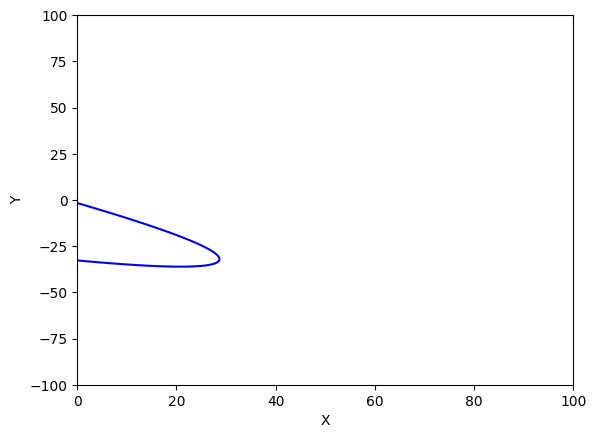

In [ ]:
x = np.linspace(0, 100, 1000)
y = np.linspace(-100, 100, 1000)
X, Y = np.meshgrid(x, y)
for i in range (3):
  a,b,c,d = (np.random.rand(4)-0.5)*10
  x1, y1 = np.random.uniform(low=0.0, high=100.0, size=(2))
  print("translation = ",x1,y1)
  # a,b,c,d = [1,1,1,1]
  print(a,b,c,d)
  theta = np.random.rand(1)*3
  print("theta", theta)

  # add rotation
  Xx = X*np.cos(theta) - Y*np.sin(theta)
  Yy = X*np.sin(theta) + Y*np.cos(theta)
  # add translation
  Xx = Xx - x1
  Yy = Yy - y1
  # parabola equation
  Z = (Yy) - a/20*(Xx)**2 - b*(Xx) - c #dividing a/20 to get wider parabola
  plt.contour(X, Y, Z, levels=[0], colors='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
 image = Image.open("/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr0.jpeg")

In [ ]:
image_np = np.array(image)

In [ ]:
image_np.shape

(3056, 2544)

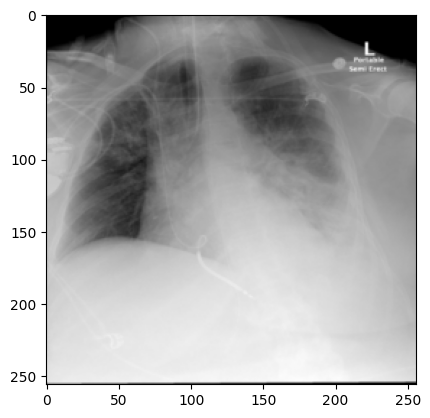

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
origin = Image.open(image_path).convert("RGB")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin = torch.permute(origin,(1,2,0))
plt.imshow(origin)
plt.show()

translation =  8.50871534510079 236.33881580087274
-2.6328981714850563 2.4240451342112412 -2.317164423303626 -3.7298440331831175
theta [2.14339971]
translation =  15.87837734968277 193.96387173145848
-1.916199536840486 -4.668733401893719 0.5732196976972448 0.7535585681289725
theta [2.27714859]
translation =  89.15413094740678 71.31432151699704
-1.0756523772702897 2.9966330863907853 3.9783651045267754 -1.8147693192624237
theta [2.20594964]
translation =  162.63708784547356 251.5110680460832
3.0437359033708056 -0.819863388421258 -1.6715413899935294 2.486913683310492
theta [1.29453707]


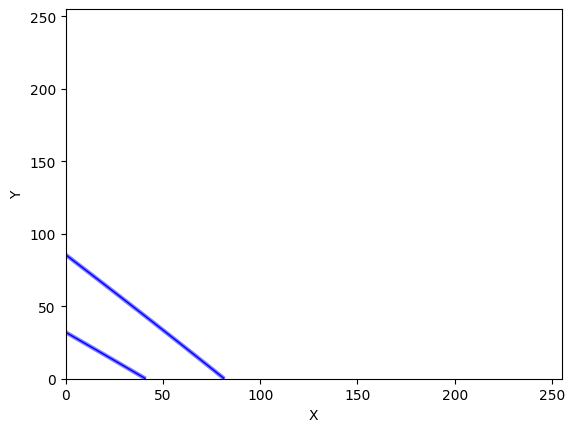

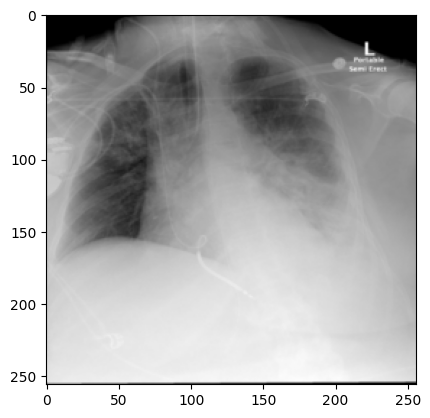

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
origin = Image.open(image_path).convert("RGB")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin = torch.permute(origin,(1,2,0))
# plt.imshow(origin)
x = np.linspace(0, 255, 1000)
y = np.linspace(0, 255, 1000)
X, Y = np.meshgrid(x, y)
for i in range (4):
  a,b,c,d = (np.random.rand(4)-0.5)*10
  # x1, y1 = np.random.uniform(low=0.0, high=255.0, size=(2))
  x1, y1 = np.random.rand(2)*255
  print("translation = ",x1,y1)
  # a,b,c,d = [1,1,1,1]
  print(a,b,c,d)
  theta = np.random.rand(1)*3
  print("theta", theta)

  # add rotation
  Xx = X*np.cos(theta) - Y*np.sin(theta)
  Yy = X*np.sin(theta) + Y*np.cos(theta)
  # Xx = X
  # Yy = Y
  # add translation
  Xx = Xx - x1
  Yy = Yy - y1
  # parabola equation
  Z = (Yy) - a/20*(Xx)**2 - b*(Xx) - c #dividing a/20 to get wider parabola
  plt.contour(X, Y, Z, levels=[0], colors='blue', alpha = 1, linewidths = 1)
  plt.contour(X, Y, Z, levels=[0], colors='blue', alpha = 0.5, linewidths = 3)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.imshow(origin)
plt.show()

In [ ]:
np.random.rand(1)

array([0.48275497])

# Save CCF masks in 256 x 256 size

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID" # read from UPMC ARDS in VeyTel database
save_dir_mask = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask/CCF_COVID" # write to mask folder

isExist_mask = os.path.exists(save_dir_mask)
if not isExist_mask:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_mask)
   print("new save directory created for segmentation mask")

arr = os.listdir(image_dir)
for image_name in tqdm(arr):

  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      out = out[0].to("cpu")

      im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
      save_path = os.path.join(save_dir_mask, image_name)
      im2.save(save_path)

100%|██████████| 1117/1117 [25:22<00:00,  1.36s/it]
